In [1]:
import numpy as np
import torch
import torchvision
import torchmetrics
import lightning.pytorch as pl 
from torchinfo import summary 
from torchview import draw_graph 
import matplotlib.pyplot as plt 
import pandas as pd

if (torch.cuda.is_available()): 
    device = ("cuda")
else:
    device = ("cpu")
print(f"Use GPU: {torch.cuda.is_available()}")

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


Use GPU: False


In [2]:
# Config Section
cfg_data_folder = "datasets/cifar10"
cfg_max_epochs  = 50;
cfg_num_workers = 5
cfg_hidden_dims = 34
cfg_num_hidden_layers = 18

cfg_logger_dir="logs"
cfg_logger_name="OL2"
cfg_logger_version="resid"

cfg_cifar10_labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

In [3]:
# Load the data set and scale to [-1,+1]
training_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder,  download=True, train=False) 

x_train = (torch.Tensor(training_dataset.data) / 127.5) - 1.0
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = (torch.Tensor(testing_dataset.data) / 127.5) - 1.0 
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# You can set a seed value here if you
# want to control the shuffling process...
rng = np.random.default_rng()
permutation = rng.permutation(x_train.shape[0]) 
split_point = int(x_train.shape[0] * 0.8) # 80%/20% split

# Split into validation/training - keep test # set aside for later...
x_val = x_train[permutation][split_point:]
y_val = y_train[permutation][split_point:]
x_train = x_train[permutation][:split_point]
y_train = y_train[permutation][:split_point]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([40000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])


In [4]:
x_train.shape

torch.Size([40000, 32, 32, 3])

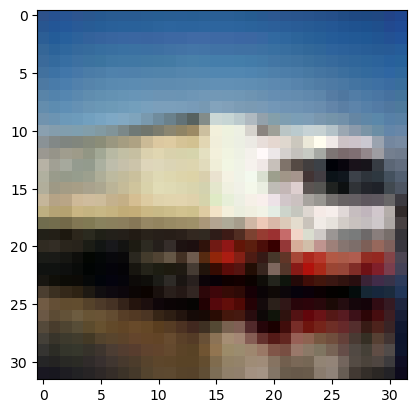

Label: Truck (idx: 9)


In [5]:
plt.imshow((x_train[0].detach().numpy() + 1.0)/2.0)
plt.show()
print(f"Label: {cfg_cifar10_labels.get(int(y_train[0]))} (idx: {y_train[0]})")

In [6]:
# Define residual layer
class ResidualLayer(torch.nn.Module): 
    def __init__(self, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.residual = torch.nn.Linear(hidden_size, hidden_size)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        y = x
        y = self.activation(self.residual(y))
        y = y + x # Add residual
        return y

In [7]:
class ResidualNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers, **kwargs):
        super().__init__(**kwargs)
        self.flatten_layer = torch.nn.Flatten()
        
        # Initial linear projection
        layers = [torch.nn.Linear(input_size.numel(), hidden_size),
                  torch.nn.ReLU(),
                  torch.nn.BatchNorm1d(hidden_size),
                  torch.nn.Dropout(0.5)
                 ]
        for _ in range(num_hidden_layers):
            layers.append(ResidualLayer(hidden_size))
            layers.append(torch.nn.ReLU())  # Use ReLU activation
            layers.append(torch.nn.BatchNorm1d(hidden_size))  # Add Layer Normalization

        self.hidden_layers = torch.nn.Sequential(*layers)
        self.output_layer = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        y = x
        y = self.flatten_layer(y)
        y = self.hidden_layers(y)
        y = self.output_layer(y)
        return y
        
    def predict(self, x):
        y = x
        y = self.forward(y)
        y = torch.softmax(y, -1)
        return y

In [9]:
# Define Trainable Module
class PLModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        
        # This creates an accuracy function
        self.model_acc = torchmetrics.classification.Accuracy(task='multiclass', 
                                                              num_classes=module.output_layer.out_features)
        # This creates a loss function
        self.model_loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true) 
        self.log('train_acc',  acc,  on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss


    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true)
        self.log('val_acc',  acc,  on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred,y_true)
        loss = self.model_loss(y_pred,y_true)
        self.log('test_acc',  acc,  on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [12]:
model = PLModel(ResidualNetwork(x_train.shape[1:],
                                len(y_train.unique()),
                                cfg_hidden_dims,
                                cfg_num_hidden_layers))

summary(model, input_size=(1,)+x_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
PLModel                                  [1, 10]                   --
├─ResidualNetwork: 1-1                   --                        --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Sequential: 2-2                   [1, 35]                   --
│    │    └─Linear: 3-1                  [1, 35]                   107,555
│    │    └─ResidualLayer: 3-2           [1, 35]                   1,260
│    │    └─ResidualLayer: 3-3           [1, 35]                   1,260
│    │    └─ResidualLayer: 3-4           [1, 35]                   1,260
│    │    └─ResidualLayer: 3-5           [1, 35]                   1,260
│    │    └─ResidualLayer: 3-6           [1, 35]                   1,260
│    │    └─ResidualLayer: 3-7           [1, 35]                   1,260
│    │    └─ResidualLayer: 3-8           [1, 35]                   1,260
│    │    └─ResidualLayer: 3-9           [1, 35]           

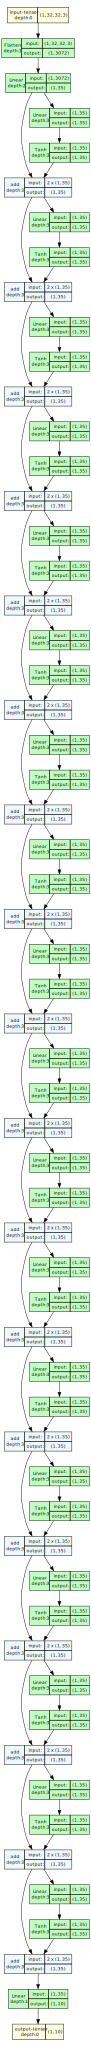

In [13]:
model_graph = draw_graph(model, input_size=(1,)+x_train.shape[1:], device=device, depth=3)
model_graph.visual_graph

In [14]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()

predictions

array([[0.00801496, 0.15890679, 0.25117776, 0.10951079, 0.02778137,
        0.05921342, 0.01442721, 0.02736656, 0.33002108, 0.01358003],
       [0.00332431, 0.01893071, 0.01615907, 0.7450904 , 0.00333001,
        0.01454075, 0.00925328, 0.02656296, 0.07958228, 0.08322626],
       [0.02763639, 0.05163046, 0.17258891, 0.30058113, 0.01994255,
        0.03853425, 0.05596001, 0.08543932, 0.14334744, 0.10433956],
       [0.03010273, 0.09438819, 0.20123799, 0.19513342, 0.01539442,
        0.07292341, 0.1299643 , 0.05904426, 0.1416413 , 0.06017001],
       [0.01090425, 0.04445066, 0.4168424 , 0.2244585 , 0.0093602 ,
        0.20224822, 0.013826  , 0.01881417, 0.04331991, 0.01577574]],
      dtype=float32)

In [15]:
model.model_loss(model(x_train[:5].to(device)),
                 y_train[:5].to(device)
                ).cpu().detach().numpy()

array(3.108437, dtype=float32)

In [16]:
model.model_acc(model(x_train[:5].to(device)),
                y_train[:5].to(device)).cpu().detach().numpy()

array(0.2, dtype=float32)

In [17]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)),
                                       shuffle=True,
                                       batch_size=250,
                                       num_workers=cfg_num_workers) # Using CFG

xy_val = torch.utils.data.DataLoader(list(zip(x_val, y_val)),
                                     shuffle=False,
                                     batch_size=250,
                                     num_workers=cfg_num_workers) # Using CFG

xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                      shuffle=False,
                                      batch_size=250,
                                      num_workers=cfg_num_workers) # Using CFG

In [18]:
# Setup Logger
logger = pl.loggers.CSVLogger("logs", name="OL2", version="resid")

In [19]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
# Validate on Model
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.10750000178813934    │
│         val_loss          │    2.7966713905334473     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.10750000178813934, 'val_loss': 2.7966713905334473}]

In [21]:
trainer.fit(model, xy_train, xy_val)


  | Name       | Type               | Params
--------------------------------------------------
0 | module     | ResidualNetwork    | 130 K 
1 | model_acc  | MulticlassAccuracy | 0     
2 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
130 K     Trainable params
0         Non-trainable params
130 K     Total params
0.522     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [22]:
# Validate on Model
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.46799999475479126    │
│         val_loss          │    1.5386158227920532     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.46799999475479126, 'val_loss': 1.5386158227920532}]

In [23]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.1075,2.796671,0,0,NaN,NaN
1,0.4016,1.728042,0,159,NaN,NaN
2,NaN,NaN,0,159,0.350750,1.858938
3,0.4309,1.647110,1,319,NaN,NaN
4,NaN,NaN,1,319,0.423725,1.647825
5,0.4315,1.615492,2,479,NaN,NaN
6,NaN,NaN,2,479,0.458250,1.553751
7,0.4395,1.583771,3,639,NaN,NaN
8,NaN,NaN,3,639,0.480325,1.485144
9,0.4586,1.543414,4,799,NaN,NaN


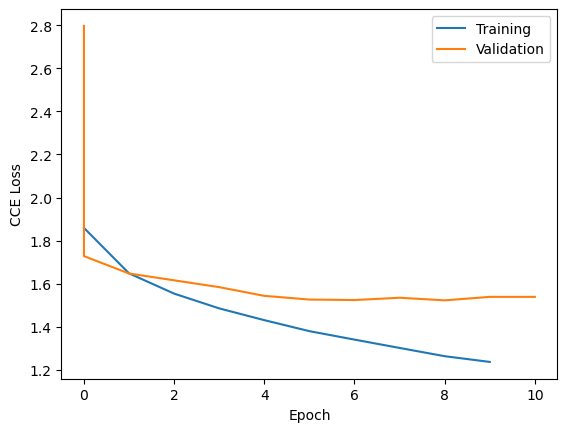

In [24]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

In [25]:
print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.10750000 0.40160000 0.43090001 0.43149999 0.43950000 0.45860001 0.47459999 0.47180000 0.46930000 0.48060000 0.46799999 0.46799999


In [26]:
print("Testing accuracy:", trainer.test(model, xy_test)[0]['test_acc'])

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4717999994754791     │
│         test_loss         │    1.5306371450424194     │
└───────────────────────────┴───────────────────────────┘

Testing accuracy: 0.4717999994754791
